# Learning to Invert Heat Conduction with Scale-invariant Updates

We now turn to a practical example that use the scale-invariant physics (SIP) updates in a more complex example. Specifically, we'll consider the heat equation, which poses some particularly interesting challenges: the differentiable physics (DP) gradient just diffuses more, while the inversion is numerically challenging. Below, we'll explain how SIPs adress the former, while a special solver can address the latter issue.

The notebook below provides a full implementation via _phiflow_ to generate data, run the DP version, and compute the improved SIP updates.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/physgrad-code.ipynb)




## Problem Statement

We consider a two-dimensional system governed by the heat equation $\frac{\partial u}{\partial t} = \nu \cdot \nabla^2 u$.
Given an initial state $x = u(t_0)$ at $t_0$, the simulator computes the state at a later time $t_*$ via $y = u(t_*) = \mathcal P(x)$.
Exactly inverting this system is only possible for $t \cdot \nu = 0$ and becomes increasingly unstable for larger $t \cdot \nu$ because initially distinct heat levels even out over time, drowning the original information in noise.
Hence the Jacobian of the physics $\frac{\partial y}{\partial x}$ is near-singular.

We'll use periodic boundary conditions and compute the result in frequency space where the physics can be computed analytically as $\hat y = \hat x \cdot e^{-k^2 (t_* - t_0)} $ , where $\hat y_k \equiv \mathcal F(y)_k$ denotes the $k$-th element of the Fourier-transformed vector $y$.
In the regular _forward_ simulation, high frequencies are dampened exponentially. We'll need to revisit this aspect for the inverse simulator.

To summarize, the inverse problem we're targeting here can be written as minimizing: 

$$L(x) = || \mathcal P(x) - y^* ||_2^2 = || \mathcal F^{-1}\left( \mathcal F(x) \cdot e^{-k^2 (t_* - t_0)} \right) - y^* ||_2^2 . $$



---

## Implementation

Below, we'll set $t\cdot \nu = 8$ on a domain consisting of 64x64 cells of unit length.
This level of diffusion is challenging, and diffuses most details while leaving only the large-scale structure intact.

We'll use phiflow with PyTorch as default backend, but this example code likewise runs with TensorFlow (just switch to `phi.tf.flow` below).



In [ ]:
!pip install --upgrade --quiet phiflow==2.2
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow
from phi.torch.flow import *    # switch to TF with "phi.tf.flow"


## Data generation

For training, we generate $x^*$ by randomly placing between 4 and 10 "hot" rectangles of random size and shape in the domain. The `generate_heat_example()` function below generates a full mini batch (via `shape.batch`) of example positions. These will be $x$ later on. They're never passed to the solver, but should be reconstructed by the neural network.



In [ ]:
def generate_heat_example(*shape, bounds: Box = None):
    shape = math.merge_shapes(*shape)
    heat_t0 = CenteredGrid(0, extrapolation.PERIODIC, bounds, resolution=shape.spatial)
    bounds = heat_t0.bounds
    component_counts = math.to_int32(4 + 7 * math.random_uniform(shape.batch))
    positions = (math.random_uniform(shape.batch, batch(components=10), channel(vector=shape.spatial.names)) - 0.5) * bounds.size * 0.8 + bounds.size * 0.5
    for i in range(10):
        position = positions.components[i]
        half_size = math.random_uniform(shape.batch, channel(vector=shape.spatial.names)) * 10
        strength = math.random_uniform(shape.batch) * math.to_float(i < component_counts)
        position = math.clip(position, bounds.lower + half_size, bounds.upper - half_size)
        component_box = Cuboid(position, half_size)
        component_mask = SoftGeometryMask(component_box)
        component_mask = component_mask.at(heat_t0)
        heat_t0 += component_mask * strength
    return heat_t0

The data is generated on-the-fly later during training, but let's look at two example $x$ for now using phiflow's `vis.plot` function:

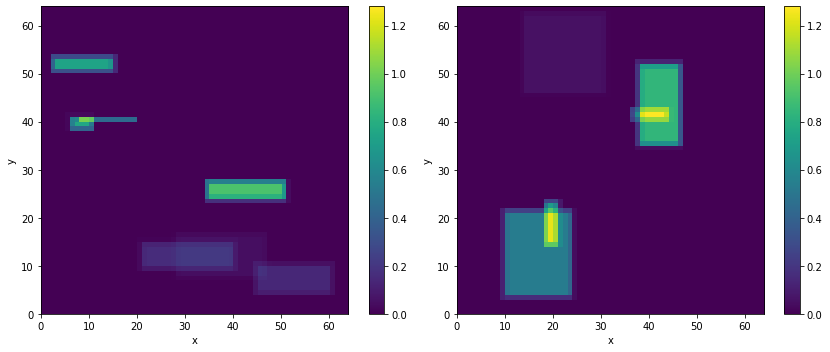

In [ ]:
vis.plot(generate_heat_example(batch(view_examples=2), spatial(x=64, y=64)));


## Differentiable physics and gradient descent

Nothing in this setup so far prevents us from using regular DP training, as described in {doc}`diffphys`.
For this diffusion case, we can write out
gradient descent update from in an analytic fashion as:
$$\Delta x_{\text{GD}} = - \eta \cdot \mathcal F^{-1}\left( e^{-k^2 (t_* - t_0)} \mathcal F(y - y^*) \right).$$

Looking at this expression, it means that gradient descent (GD) with the gradient from the differentiable simulator applies the forward physics to the gradient vector itself. This is surprising: the forward simulation performs diffusion, and now the backward pass performs even more of it, instead of somehow undoing the diffusion? Unfortunately, this is the inherent and "correct" behavior of DP, and it results in updates that are stable but lack high frequency spatial information.

Consequently, GD-based optimization methods converge slowly on this task after fitting the coarse structure and have severe problems in recovering high-frequency details, as will be demonstrated below.
This is not because the information is fundamentally missing but because GD cannot adequately process high-frequency details.

For the implementation below, we will simply use `y = diffuse.fourier(x, 8., 1)` for the forward pass, and then similarly compute an $L^2$ loss for two $y$ fields to which `diffuse.fourier( , 8., 1)` is applied.



## Stable SIP gradients

What is more interesting in the context of this chapter is the improved update step computed via the inverse simulator, the _SIP_ update. In line with the previous sections, we'll call this update $\Delta x_{\text{PG}}.$

The frequency formulation of the heat equation can be inverted analytically, yielding
$\hat x_k = \hat y_k \cdot e^{k^2 (t_* - t_0)}$.
This allows us to define the update 

$$\Delta x_{\text{PG}} = - \eta \cdot \mathcal F^{-1}\left( e^{k^2 (t_* - t_0)} \mathcal F(y - y^*) \right).$$

Here, high frequencies are multiplied by exponentially large factors, resulting in numerical instabilities.
When applying this formula directly to the gradients, it can lead to large oscillations in $\Delta x_{\text{PG}}$.

Note that these numerical instabilities also occur when computing the gradients in real space instead of frequency space.
However, frequency space allows us to more easily quantify them.

Now we can leverage our knowledge of the physical simulation process to construct a stable inverse:
the numerical instabilities can be avoided by taking a probabilistic viewpoint.
The observed values $y$ contain a certain amount of noise $n$, with the remainder constituting the signal $s = y - n$.
For the noise, we assume a normal distribution $n \sim \mathcal N(0, \epsilon \cdot y)$ with $\epsilon > 0$ and for the signal, we assume that it arises from reasonable values of $x$ so that $y \sim \mathcal N(0, \delta \cdot e^{-k^2})$ with $\delta > 0$.
With this, we can estimate the probability of an observed value arising from the signal using Bayes' theorem
$p(s | v) = \frac{p(v | s) \cdot p(s)}{p(v | s) \cdot p(s) + p(v | n) \cdot p(n)}$ where we assume the priors $p(s) = p(n) = \frac 1 2$.
Based on this probability, we dampen the amplification of the inverse physics which yields a stable inverse.

Gradients computed in this way hold as much high-frequency information as can be extracted given the noise that is present.
This leads to a much faster convergence and more precise solution than any generic optimization method.
The cell below implements this probabilistic approach, with `probability_signal` in `apply_damping()` containing the parts of the signal to be dampened.
The `inv_diffuse()` functions employs it to compute a stabilized inverse diffusion process.


In [ ]:
def apply_damping(kernel, inv_kernel, amp, f_uncertainty, log_kernel):
    signal_prior = 0.5
    expected_amp = 1. * kernel.shape.get_size('x') * inv_kernel  # This can be measured
    signal_likelihood = math.exp(-0.5 * (abs(amp) / expected_amp) ** 2) * signal_prior  # this can be NaN
    signal_likelihood = math.where(math.isfinite(signal_likelihood), signal_likelihood, math.zeros_like(signal_likelihood))
    noise_likelihood = math.exp(-0.5 * (abs(amp) / f_uncertainty) ** 2) * (1 - signal_prior)
    probability_signal = math.divide_no_nan(signal_likelihood, (signal_likelihood + noise_likelihood))
    action = math.where((0.5 >= probability_signal) | (probability_signal >= 0.68), 2 * (probability_signal - 0.5), 0.)  # 1 sigma required to take action
    prob_kernel = math.exp(log_kernel * action)
    return prob_kernel, probability_signal


def inv_diffuse(grid: Grid, amount: float, uncertainty: Grid):
    f_uncertainty: math.Tensor = math.sqrt(math.sum(uncertainty.values ** 2, dim='x,y'))  # all frequencies have the same uncertainty, 1/N in iFFT
    k_squared: math.Tensor = math.sum(math.fftfreq(grid.shape, grid.dx) ** 2, 'vector')
    fft_laplace: math.Tensor = -(2 * np.pi) ** 2 * k_squared
    # --- Compute sharpening kernel with damping ---
    log_kernel = fft_laplace * -amount
    log_kernel_clamped = math.minimum(log_kernel, math.to_float(math.floor(math.log(math.wrap(np.finfo(np.float32).max)))))  # avoid overflow
    raw_kernel = math.exp(log_kernel_clamped)  # inverse diffusion FFT kernel, all values >= 1
    inv_kernel = math.exp(-log_kernel)
    amp = math.fft(grid.values)
    kernel, sig_prob = apply_damping(raw_kernel, inv_kernel, amp, f_uncertainty, log_kernel)
    # --- Apply and compute uncertainty ---
    data = math.real(math.ifft(amp * math.to_complex(kernel)))
    uncertainty = math.sqrt(math.sum(((f_uncertainty * kernel) ** 2))) / grid.shape.get_size('x')  # 1/N normalization in iFFT
    uncertainty = grid * 0 + uncertainty
    return grid.with_values(data), uncertainty, abs(amp), raw_kernel, kernel, sig_prob

## Neural network and loss function

For the neural network, we use a simple U-net architecture for the SIP and the regular DP+Adam version (in line with the previous sections, we'll denote it as `GD`). 
We train with a batch size of 128 and a constant learning rate of $\eta = 10^{-3}$, using 64 bit precision for physics but 32 bits for the network.
The network updates are computed with TensorFlow's or PyTorch's automatic differentiation.



In [ ]:
math.set_global_precision(64)
BATCH = batch(batch=128)
STEPS = 50

math.seed(0)
net = u_net(1, 1)
optimizer = adam(net, 0.001)

Now we'll define loss function for phiflow.
The gradients for the network weights are always computed as d(loss_function)/d$\theta$.

For SIP, we invert the physics, and then define the proxy loss as $L^2$(prediction - correction), where correction is taken as constant. Below this is realized via `x = field.stop_gradient(prediction)`. This L2 loss triggers the backprop towards the neural network weights. For SIP, the `y_l2` is only computed for comparison, and is not crucial for training.

The Adam / GD version for `sip=False` simply computes the L2 difference of the predicted, diffused $y$ field to the target, and backprops through the operations for the gradient.

We also compute the reference $y = \mathcal P(x^*)$ in the loss function on-the-fly.


In [ ]:
# @math.jit_compile
def loss_function(net, x_gt: CenteredGrid, sip: bool):
    y_target = diffuse.fourier(x_gt, 8., 1)
    with math.precision(32):
        prediction = field.native_call(net, field.to_float(y_target)).vector[0]
        prediction += field.mean(x_gt) - field.mean(prediction)
    x = field.stop_gradient(prediction)
    if sip:
        y = diffuse.fourier(x, 8., 1)
        dx, _, amp, raw_kernel, kernel, sig_prob = inv_diffuse(y_target - y, 8., uncertainty=abs(y_target - y) * 1e-6)
        correction = x + dx
        y_l2 = field.l2_loss(y - y_target)  # not important, just for tracking 
        loss = field.l2_loss(prediction - correction) # proxy L2 loss for network
    else:
        y = diffuse.fourier(prediction, 8., 1)
        loss = y_l2 = field.l2_loss(y - y_target) # for Adam we backprop through the loss and y
    return loss, x, y, field.l2_loss(x_gt - x), y_l2


## Training

In the training loop, we generate data on-the-fly via `generate_heat_example()` and use phiflow's `update_weights()` function to call the correct functions of the chosen backend. Note that we're only printing the loss of the first 5 steps below for clarity, the whole history is collected in the `loss_` lists. The following cell runs the SIP version of the training:


In [ ]:
loss_sip_x=[]; loss_sip_y=[] 
for training_step in range(STEPS):
    data = generate_heat_example(spatial(x=64, y=64), BATCH)
    loss_value, x_sip, y_sip, x_l2, y_l2 = update_weights(net, optimizer, loss_function, net, data, sip=True)
    loss_sip_x.append(float(x_l2.mean)) 
    loss_sip_y.append(float(y_l2.mean))
    if(training_step<5): print("SIP L2 loss x ; y: "+format(float(x_l2.mean))+" ; "+format(float(y_l2.mean)) )

SIP L2 loss x ; y: 187.2586057892786 ; 59.48433060883144
SIP L2 loss x ; y: 70.21347147390776 ; 13.783476203544797
SIP L2 loss x ; y: 51.91472605336263 ; 5.72813432496525
SIP L2 loss x ; y: 39.46109317565444 ; 4.4424629873554045
SIP L2 loss x ; y: 34.611490797378366 ; 3.359133206049436


And now we can repeat the training with the DP version using Adam, deactivating the SIP update via `sip=False`:

In [ ]:
math.seed(0)
net_gd = u_net(1, 1)
optimizer_gd = adam(net_gd, 0.001)

loss_gd_x=[]; loss_gd_y=[] 
for training_step in range(STEPS):
    data = generate_heat_example(spatial(x=64, y=64), BATCH)
    loss_value, x_gd, y_gd, x_l2, y_l2 = update_weights(net_gd, optimizer_gd, loss_function, net_gd, data, sip=False)
    loss_gd_x.append(float(x_l2.mean)) 
    loss_gd_y.append(float(y_l2.mean))
    if(training_step<5): print("GD L2 loss x ; y: "+format(float(x_l2.mean))+" ; "+format(float(y_l2.mean)) )

GD L2 loss x ; y: 187.2586057892786 ; 59.48433060883144
GD L2 loss x ; y: 104.37856249315794 ; 20.323700695817763
GD L2 loss x ; y: 72.5135221242247 ; 7.211550418534284
GD L2 loss x ; y: 59.74792697261851 ; 5.3912096056107135
GD L2 loss x ; y: 50.49939087445511 ; 3.6758429757536093


## Evaluation

Now we can evaluate how the two variants behave in direct comparison. Note that due to the on-the-fly generation of randomized data, all samples are previously unseen, and hence we'll directly use the training curves here to draw  conclusions about the performance of the two approaches.

The following graph shows the $L^2$ error over training in terms of the reconstructed $x$ input, the main goal of our training.

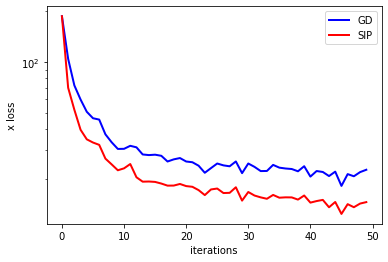

In [ ]:
import pylab as plt
fig = plt.figure().gca()
pltx = range(len(loss_gd_x)) 
fig.plot(pltx, loss_gd_x , lw=2, color='blue',      label="GD")  
fig.plot(pltx, loss_sip_x  , lw=2, color='red', label="SIP")
plt.xlabel('iterations'); plt.ylabel('x loss'); plt.legend(); plt.yscale("log")


The log-scale for the loss in $x$ nicely highlights that the SIP version does inherently better, and shows a significantly improved convergence for the NN training. This is purely caused by the better signal for the physics via the proxy loss. As shown in `loss_function()`, both variants use the same backprop-based update to change the weights of the NN. The improvements purely stem from the higher-order step in $y$ space computed by the inverse simulator.

Just out of curiosity, we can also compare how the two versions compare in terms of difference in the output space $y$.

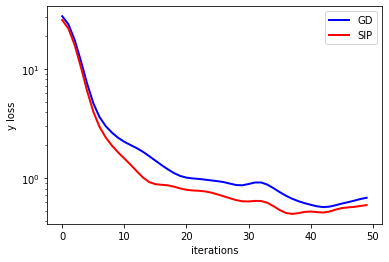

In [ ]:
fig = plt.figure().gca()
pltx = range(len(loss_gd_y)) 
import scipy # for filtering
fig.plot(pltx, scipy.ndimage.filters.gaussian_filter1d(loss_gd_y,sigma=2)  , lw=2, color='blue',      label="GD")  
fig.plot(pltx, scipy.ndimage.filters.gaussian_filter1d(loss_sip_y ,sigma=2), lw=2, color='red', label="SIP")
plt.xlabel('iterations'); plt.ylabel('y loss'); plt.legend(); plt.yscale("log")


There's likewise an improvements for SIPs, but it is not as pronounced as in $x$ space. Luckily, the $x$ reconstruction is the primary target, and hence of higher importance for the inverse problem at hand.

The differences in terms of $L^2$ error are also very obvious in direct comparison. The following cell plots a reconstruction from GD & Adam next to the SIP version, and the ground truth on the right. The difference is obvious: the SIP reconstruction is significantly sharper, and contains fewer halos than the GD version. This is a direct consequence of the undesirable behavior of GD applying diffusion to the backpropagated gradient, instead of working against it.

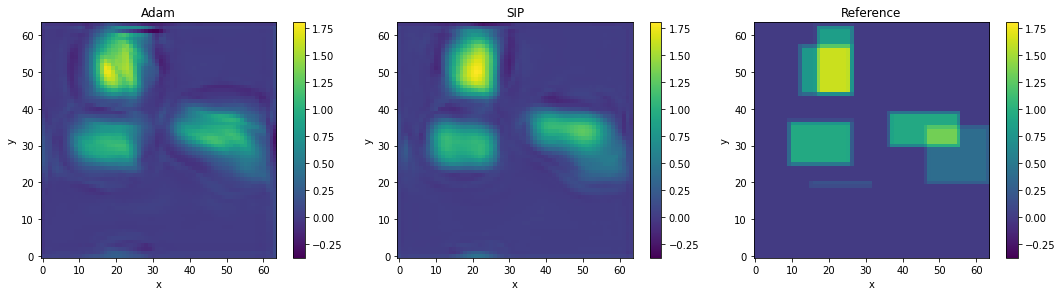

In [ ]:
plt = vis.plot(x_gd.values.batch[0], x_sip.values.batch[0], data.values.batch[0], size=(15,4) )
plt.axes[0].title="Adam"; plt.axes[1].title="SIP"; plt.axes[2].title="Reference";


## Next steps

* For this example, it's worth experimenting with various training parameters: run the training longer, with varying learning rates, and different network sizes (or even different architectures).
